In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.sparse.linalg as spLA
import networkx as nx

import sys
sys.path.insert(1, "../")

import SpringRank_tools as sr
import tools as tl

from time import time
from copy import deepcopy as copy

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

## Update Process

In [60]:
def Laplacian(G):
    k_in = np.sum(G, 0)
    k_out = np.sum(G, 1)
    return np.diag(k_in + k_out) - (A + A.T)

def operator_P(x, P):
    if len(x.shape) == 2:
        x_P = x[P][:, P]
    elif len(x.shape) == 1:
        x_P = x[P]
    else:
        raise ValueError("invalid shape")
    return x_P

def get_neighbors(G, P):
    idx_0 = set(np.nonzero(G[P])[0])
    idx_1 = set(np.nonzero(G[:,P])[0])
    N = idx_0.union(idx_1) - set(P)
    return list(N)

In [61]:
def update_ranks(A, s_0, P, num_iter=100, tol=1e-7):
    L = Laplacian(A)
    s_est = copy(s_0)
    d_hat = np.sum(A, 1) - np.sum(A, 0)
    RHS = d_hat - np.matmul(L, s_0)

    L_p = operator_P(L, P)
    RHS_p = operator_P(RHS, P)
    delta_p = LA.solve(L_p, RHS_p)
    s_est[P] = s_est[P] + delta_p
    
    N = get_neighbors(A, P)
    for i in range(num_iter):
        L_n = operator_P(L, N)
        RHS_n = operator_P(d_hat - np.matmul(L, s_est), N)
        delta_n = LA.solve(L_n, RHS_n)
        s_est[N] = s_est[N] + delta_n
        N = get_neighbors(A, N)
    
    return s_est

def kth_order_update(A, s_0, N0, order):
    L = Laplacian(A)
    s_est = copy(s_0)
    d_hat = np.sum(A, 1) - np.sum(A, 0)
    RHS = d_hat - np.matmul(L, s_0)
    
    N = set(N0)
    for k in range(order):
        N = N.union(get_neighbors(A, list(N)))
    N = list(N)
    
    L_n = operator_P(L, N)
    RHS_n = operator_P(RHS, N)
    delta_n = LA.solve(L_n, RHS_n)
    s_est[N] = s_est[N] + delta_n
    
    return s_est, N

## Test on a small network

In [62]:
N = 5

A_0 = np.zeros((N, N))
A_0[0, :] = np.array([0, 3, 0, 0, 0])
A_0[1, :] = np.array([10, 0, 6, 0, 0])
A_0[2, :] = np.array([0, 6, 0, 7, 0])
A_0[3, :] = np.array([0, 0, 0, 0, 1])
A_0[4, :] = np.array([0, 0, 0, 3, 0])

print("Network:")
print(A_0)

s_0 = sr.SpringRank(A_0)
s_0 = tl.adjust_ranks(s_0, A_0, p_ij=0.8)

print("Ranks:")
print(s_0)

Network:
[[ 0.  3.  0.  0.  0.]
 [10.  0.  6.  0.  0.]
 [ 0.  6.  0.  7.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  3.  0.]]
Ranks:
[0.84561984 1.83217635 1.83217639 0.         0.91608817]


Add some edges between two nodes

In [63]:
# fix nodes
node_x = 0
node_y = 2

# fix number of edges
A_xy = 1
A_yx = 0

# update network
A = copy(A_0)
A[node_x, node_y] += A_xy
A[node_y, node_x] += A_yx

print("Updated network:")
print(A)

# calculate new ranks
s = sr.SpringRank(A)
s = tl.adjust_ranks(s, A, p_ij=0.8)

print("Updated ranks:")
print(s)

Updated network:
[[ 0.  3.  1.  0.  0.]
 [10.  0.  6.  0.  0.]
 [ 0.  6.  0.  7.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  3.  0.]]
Updated ranks:
[1.28195308 2.11207029 1.90191406 0.         0.95095706]


Estimate updated ranks using $\infty$ recursion 

In [64]:
P = [node_x, node_y]
s_est = update_ranks(A, s_0, P)
s_est = tl.adjust_ranks(s_est, A, p_ij=0.8, interval=(-10, 20))

print("Estimated ranks:")
print(s_est)

print("L2 error:")
print(LA.norm(s - s_est, ord=2))

Estimated ranks:
[1.0440893  1.72014985 1.54897817 0.         1.4189711 ]
L2 error:
0.7441651058717121


## Test on larger network

In [118]:
beta = 0.5
p_ij = 1 / (1 + np.exp(-2*beta))
alpha = 1
N = 200
K = 10

A_0 = sr.SpringRank_planted_network(N, beta, alpha, K)
s_0 = sr.SpringRank(A_0)
s_0 = tl.adjust_ranks(s_0, A_0, p_ij=p_ij)

In [119]:
node_x = 35
node_y = 70
A_xy = 1
A_yx = 0

A = copy(A_0)
A[node_x, node_y] += A_xy
A[node_y, node_x] += A_yx

In [120]:
s = sr.SpringRank(A)
s = tl.adjust_ranks(s, A, p_ij=p_ij)

print("Difference:")
print(LA.norm(s - s_0, ord=2))

Difference:
0.8525148474004094


In [121]:
P = [node_x, node_y]
s_est = update_ranks(A, s_0, P, num_iter=10, tol=1e-1)
s_est = tl.adjust_ranks(s_est, A, p_ij=p_ij, interval=(-10, 20))

print("L2 error:")
print(LA.norm(s - s_est, ord=2))

L2 error:
57.94857714331464


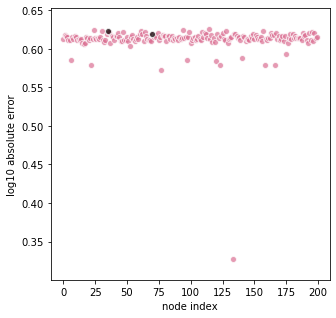

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(np.arange(len(s)), np.log10(np.abs(s_est-s)),
           color="palevioletred", edgecolor="white", alpha=0.7)

ax.scatter([node_x,node_y], np.log10(np.abs(s_est-s))[[node_x,node_y]],
           color="black", edgecolor="white", alpha=0.7)

# ax.scatter(s[621], s_est[621],
#            color="deepskyblue", edgecolor="white", alpha=0.7)

ax.set_xlabel("node index")
ax.set_ylabel("log10 absolute error")

plt.show()

### kth order update

In [123]:
s_all = []
fraction_nodes = []
errors = []
elapsed_times = []

max_order = 5
orders = list(range(max_order+1))

num_reps = 10

baseline_time = 0
for i in range(num_reps):
    start_time = time()
    _ = sr.SpringRank(A)
    end_time = time()
    baseline_time += end_time - start_time
baseline_time /= num_reps

for k in orders:
    
    elapsed_time_k = 0
    for i in range(num_reps):
        start_time = time()
        s_k, N_k = kth_order_update(A, s_0, P, order=k)
        end_time = time()
        elapsed_time_k += end_time - start_time
    elapsed_times.append(elapsed_time_k / num_reps)
    
    fraction_k = len(N_k) / N
    fraction_nodes.append(fraction_k)
    
    s_k = tl.adjust_ranks(s_k, A, p_ij=p_ij)
    s_all.append(s_k)
    
    error_k = LA.norm(s_k - s, ord=2)
    errors.append(error_k)

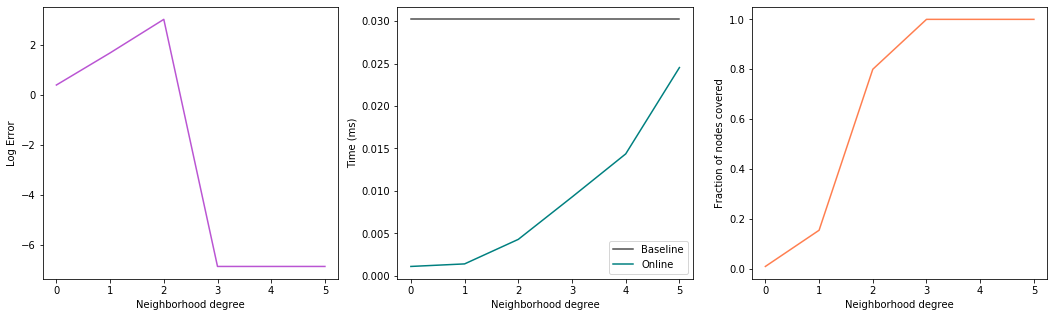

In [124]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    ax[i].set_xlabel("Neighborhood degree")
    ax[i].set_xticks(orders)

ax[0].plot(orders, np.log(errors), color="mediumorchid")
ax[0].set_ylabel("Log Error")


ax[1].plot(orders, [baseline_time]*len(orders), color='black', alpha=0.7, label="Baseline")
ax[1].plot(orders, elapsed_times, color="teal", label="Online")
ax[1].set_ylabel("Time (ms)")
ax[1].legend()


ax[2].plot(orders, fraction_nodes, color="coral")
ax[2].set_ylabel("Fraction of nodes covered")

plt.show()